# Convolutional Neural Network

In [38]:
import sys
sys.path.insert(1, '../00_Classes')
import numpy as np
import pandas as pd
from datetime import datetime
import jupyprint.jupyprint as jp
import matplotlib.pyplot as plt

import CNN_Class

CNN = CNN_Class.MyCNN()

## Train and Test Mnist Conv

In [39]:
import numpy as np

# Load data
Images = loadMNISTImages('MNIST/t10k-images.idx3-ubyte')
Labels = loadMNISTLabels('MNIST/t10k-labels.idx1-ubyte')

np.random.seed(1)

W1 = 1e-2 * np.random.randn(9, 9, 20)
W5 = (2 * np.random.rand(100, 2000) - 1) * np.sqrt(6) / np.sqrt(360 + 2000)
Wo = (2 * np.random.rand(10, 100) - 1) * np.sqrt(6) / np.sqrt(10 + 100)

X = Images[:, :, :7000]
D = Labels[:7000]

# Training
for epoch in range(10):
    print("Epoch:", epoch + 1)
    W1, W5, Wo = SGD_MnistConv(W1, W5, Wo, X, D)

# Save model weights
with h5py.File('MnistConv.h5', 'w') as hf:
    hf.create_dataset('W1', data=W1)
    hf.create_dataset('W5', data=W5)
    hf.create_dataset('Wo', data=Wo)

# Evaluation
X_test = Images[:, :, 7001:10000]
D_test = Labels[7001:10000]
acc = 0
N = len(D_test)

for k in range(N):
    print("Sample:", k + 1)
    x = X_test[:, :, k]
    y1 = Conv(x, W1)
    y2 = ReLU(y1)
    y3 = Pool(y2)
    y4 = y3.flatten()
    v5 = np.dot(W5, y4)
    y5 = ReLU(v5)
    v = np.dot(Wo, y5)
    y = Softmax(v)
    
    i = np.argmax(y)
    if i == D_test[k]:
        acc += 1

acc = acc / N
print('Accuracy is %f' % acc)


NameError: name 'loadMNISTImages' is not defined

In [40]:
import numpy as np
import gzip

def load_MNIST_images(filename):
	with gzip.open(filename, 'r') as f:
		# first 4 bytes is a magic number
		magic_number    = int.from_bytes(f.read(4), 'big')
		# second 4 bytes is the number of images
		image_count     = int.from_bytes(f.read(4), 'big')
		# third 4 bytes is the row count
		row_count       = int.from_bytes(f.read(4), 'big')
		# fourth 4 bytes is the column count
		column_count    = int.from_bytes(f.read(4), 'big')
		
		# rest is the image pixel data, each pixel is stored as an unsigned byte
		# pixel values are 0 to 255
		images = np.frombuffer(f.read(), dtype=np.uint8)\
			.reshape((image_count, row_count, column_count))
	# images.shape --> (10000, 28, 28)
	return images


def load_MNIST_labels(filename):
	with gzip.open(filename, 'r') as f:
		# first 4 bytes is a magic number
		magic_number    = int.from_bytes(f.read(4), 'big')
		# second 4 bytes is the number of labels
		label_count     = int.from_bytes(f.read(4), 'big')
		
		# rest is the label data, each label is stored as unsigned byte
		# label values are 0 to 9
		label_data      = f.read()
		labels = np.frombuffer(label_data, dtype=np.uint8)
	# labels.shape --> (10000,)
	return labels

images = load_MNIST_images('t10k-images-idx3-ubyte.gz')
labels = load_MNIST_labels('t10k-labels-idx1-ubyte.gz')

In [41]:
print('images shape', images.shape)
print('labels shape', labels.shape)

images shape (10000, 28, 28)
labels shape (10000,)


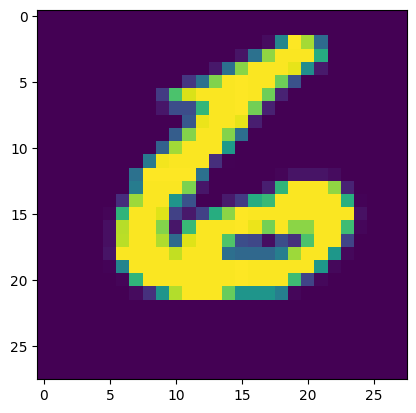

In [42]:
import matplotlib.pyplot as plt
# image = np.asarray(images[0]).squeeze()
plt.imshow(images[9999])
plt.show()

Pool

In [43]:
from scipy.signal import convolve2d

def Pool(x):
    xrow, xcol, numFilters = x.shape
    y = np.zeros((xrow // 2, xcol // 2, numFilters))  # Divisione intera per 2
    
    for k in range(numFilters):
        filter = np.ones((2, 2)) / (2 * 2)
        image = convolve2d(x[:, :, k], filter, mode='valid')
        y[:, :, k] = image[0::2, 0::2]  # prendo la media e la metto nel pixel che scelgo ogni 4
        
    return y

# Esempio di utilizzo:
x = np.zeros((6, 6, 3))

for i in range(6) :
    for j in range(6):
        if i < 3 and j < 3:
            x[i,j,:] = 1
        elif i >= 3 and j >= 3:
            x[i,j,:] = 2
        elif i < 3 and j >= 3:
            x[i,j,:] = 3

y = Pool(x)
print(x[:,:,0])
print(y[:,:,0])


[[1. 1. 1. 3. 3. 3.]
 [1. 1. 1. 3. 3. 3.]
 [1. 1. 1. 3. 3. 3.]
 [0. 0. 0. 2. 2. 2.]
 [0. 0. 0. 2. 2. 2.]
 [0. 0. 0. 2. 2. 2.]]
[[1.  2.  3. ]
 [0.5 1.5 2.5]
 [0.  1.  2. ]]


conv

In [44]:
def Conv(x, W):
    wrow, wcol, numFilters = W.shape
    xrow, xcol, _ = x.shape

    yrow = xrow - wrow + 1
    ycol = xcol - wcol + 1

    y = np.zeros((yrow, ycol, numFilters))

    for k in range(numFilters):
        filter = W[:, :, k]
        filter = np.rot90(filter, 2)
        y[:, :, k] = convolve2d(x[:, :, k], filter, mode='valid')

    return y

# Esempio di utilizzo:
x = np.zeros((6, 6, 3))

for i in range(6) :
    for j in range(6):
        if i < 3 and j < 3:
            x[i,j,:] = 1
        elif i >= 3 and j >= 3:
            x[i,j,:] = 2
        elif i < 3 and j >= 3:
            x[i,j,:] = 3


W = np.ones((2, 2, 3))

y = Conv(x, W)

print('W ', W)
print('x ', x[:,:,0])
print('y ', y[:,:,:])

W  [[[1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]]]
x  [[1. 1. 1. 3. 3. 3.]
 [1. 1. 1. 3. 3. 3.]
 [1. 1. 1. 3. 3. 3.]
 [0. 0. 0. 2. 2. 2.]
 [0. 0. 0. 2. 2. 2.]
 [0. 0. 0. 2. 2. 2.]]
y  [[[ 4.  4.  4.]
  [ 4.  4.  4.]
  [ 8.  8.  8.]
  [12. 12. 12.]
  [12. 12. 12.]]

 [[ 4.  4.  4.]
  [ 4.  4.  4.]
  [ 8.  8.  8.]
  [12. 12. 12.]
  [12. 12. 12.]]

 [[ 2.  2.  2.]
  [ 2.  2.  2.]
  [ 6.  6.  6.]
  [10. 10. 10.]
  [10. 10. 10.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 4.  4.  4.]
  [ 8.  8.  8.]
  [ 8.  8.  8.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 4.  4.  4.]
  [ 8.  8.  8.]
  [ 8.  8.  8.]]]


plot features

In [46]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# Carica i dati dal file .mat
data = sio.loadmat('MnistConv.mat')
X = data['X']
W1 = data['W1']
W5 = data['W5']
Wo = data['Wo']

def display_network(data, title=''):
    fig, ax = plt.subplots()
    num_filters = data.shape[1]
    filter_size = int(np.sqrt(data.shape[0]))
    num_cols = int(np.sqrt(num_filters))
    num_rows = (num_filters + num_cols - 1) // num_cols
    grid = np.zeros((num_rows * filter_size, num_cols * filter_size))
    
    for i in range(num_filters):
        row = i // num_cols
        col = i % num_cols
        grid[row*filter_size:(row+1)*filter_size, col*filter_size:(col+1)*filter_size] = data[:, i].reshape((filter_size, filter_size))
    
    ax.imshow(grid, cmap='gray', interpolation='nearest')
    ax.set_title(title)
    ax.axis('off')
    plt.show()

# Esempio di utilizzo
k = 1
x = X[:, :, k]
y1 = Conv(x, W1)
y2 = CNN.ReLU(y1)
y3 = Pool(y2)
y4 = y3.reshape(-1, 1)
v5 = np.dot(W5, y4)
y5 = CNN.ReLU(v5)
v = np.dot(Wo, y5)
y = CNN.Softmax(v)

# Visualizza l'immagine di input
plt.figure()
display_network(x.reshape(-1, 1), title='Input Image')

# Visualizza i filtri di convoluzione
convFilters = np.zeros((9*9, 20))
for i in range(20):
    filter = W1[:, :, i]
    convFilters[:, i] = filter.flatten()

plt.figure()
display_network(convFilters, title='Convolution Filters')

# Visualizza le caratteristiche [Convolution]
fList = np.zeros((20*20, 20))
for i in range(20):
    feature = y1[:, :, i]
    fList[:, i] = feature.flatten()

plt.figure()
display_network(fList, title='Features [Convolution]')

# Visualizza le caratteristiche [Convolution + ReLU]
fList = np.zeros((20*20, 20))
for i in range(20):
    feature = y2[:, :, i]
    fList[:, i] = feature.flatten()

plt.figure()
display_network(fList, title='Features [Convolution + ReLU]')

# Visualizza le caratteristiche [Convolution + ReLU + MeanPool]
fList = np.zeros((10*10, 20))
for i in range(20):
    feature = y3[:, :, i]
    fList[:, i] = feature.flatten()

plt.figure()
display_network(fList, title='Features [Convolution + ReLU + MeanPool]')


FileNotFoundError: [Errno 2] No such file or directory: 'MnistConv.mat'